<a href="https://colab.research.google.com/github/victor-armegioiu/Time-Series-Prediction/blob/main/VK_Energie_LSTM_Auto_Regression_(Heat_Demand)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Project (VK Energie - Forecasting Heat Demand)

# Boilerplate 

This section does necesary imports, loads/parses the data.

In [3]:
# Non-neural based math imports.
import numpy as np

import scipy 
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# Data loading
import pandas as pd
import csv

In [5]:
# Drawing stuff.
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')

In [6]:
# Neural networks stuff.
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [7]:
df = pd.DataFrame()
reader = csv.reader(
    open("Oberbayern.csv"), delimiter=";")

rows = [row for row in reader]
df = df.append(rows[1:])

In [8]:
df.columns = ['TimestampUtc', 'Heat Demand', 'Ambient Temperature',  
              'Solar Irradiance']

In [9]:
for column in df.columns[1:]:
  df[column] = df[column].astype(float)

# Data Analysis

This section covers the following analyses on the dataset:


*   Peaking at samples from the data.
*   Missing values count
*   Overall statistics on the regressors/regressands (mean, max, std, etc). Plots for the histograms.
*   Correlation analysis - Making sure the correlations between the features and the targets make sense, as well as ensuring we don't have too strong a linear correlation between the features. 



In [ ]:
df

,TimestampUtc,Heat Demand,Ambient Temperature,Solar Irradiance
0,2020-02-26 17:00:00+01:00,5715.7325,1.370000,0.050000
1,2020-02-26 18:00:00+01:00,5810.5000,0.880000,0.000000
2,2020-02-26 19:00:00+01:00,6059.9000,0.670000,0.000000
3,2020-02-26 20:00:00+01:00,6114.0850,0.600000,0.000000
4,2020-02-26 21:00:00+01:00,6027.0525,0.540000,0.000000
...,...,...,...,...
5941,2020-11-02 12:00:00+01:00,3431.5000,16.787415,5.718750
5942,2020-11-02 13:00:00+01:00,3221.2500,16.833160,7.406250
5943,2020-11-02 14:00:00+01:00,3153.7500,16.731232,2.312500
5944,2020-11-02 15:00:00+01:00,2795.1250,16.396759,7.906250


In [ ]:
df.isnull().sum()

TimestampUtc           0
Heat Demand            0
Ambient Temperature    0
Solar Irradiance       0
dtype: int64

In [ ]:
df.columns

Index(['TimestampUtc', 'Heat Demand', 'Ambient Temperature',
       'Solar Irradiance'],
      dtype='object')

In [ ]:
# Compute and store pairwise correlations between features and
# targets.
correlations = {}
for col1 in df.columns[1:]:
  for col2 in df.columns[1:]:
    if col1 != col2:
      r2_correlation_coeff = stats.pearsonr(df[col1], df[col2])[0]
      correlations[col1, col2] = r2_correlation_coeff

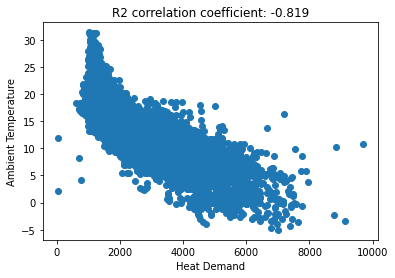

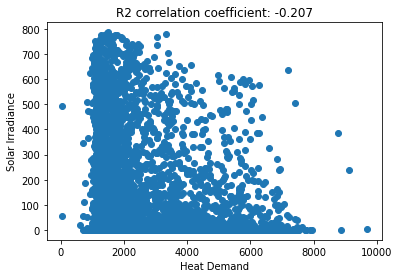

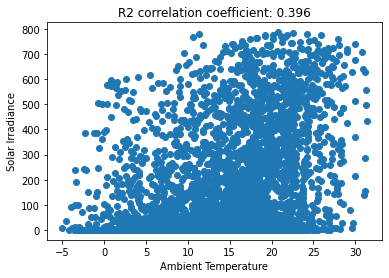

In [ ]:
# Plot all pairwise features/targets/
relevant_columns = df.columns[1:] 

for i in range(len(relevant_columns)):
  for j in range(i + 1, len(relevant_columns)):
    col_i, col_j = relevant_columns[i], relevant_columns[j]
    plt.scatter(df[col_i], df[col_j])
    plt.xlabel(col_i)
    plt.ylabel(col_j)

    r2_correlation_coeff = round(correlations[col_i, col_j], 3)
    plt.title('R2 correlation coefficient: {}'.format(r2_correlation_coeff))
    plt.show()


count    5946.000000
mean     2753.058015
std      1530.114730
min        43.000000
25%      1514.583328
50%      2222.491250
75%      3754.158808
max      9681.533203
Name: Heat Demand, dtype: float64


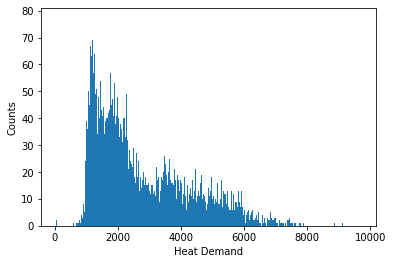


count    5946.000000
mean       13.007976
std         6.339653
min        -5.020000
25%         8.600000
50%        13.198389
75%        17.370000
max        31.371857
Name: Ambient Temperature, dtype: float64


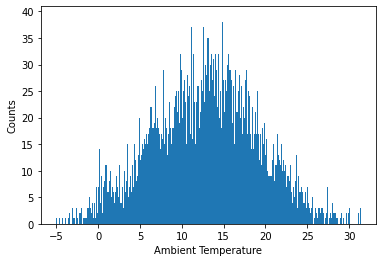


count    5946.000000
mean      105.020707
std       184.026273
min        -0.260000
25%         0.000000
50%         1.812500
75%       131.907500
max       787.470000
Name: Solar Irradiance, dtype: float64


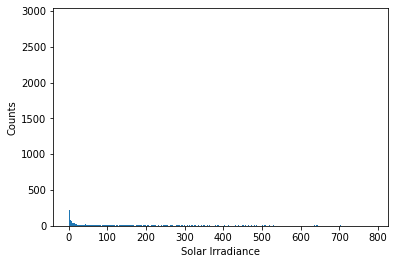

In [ ]:
for column in df.columns[1:]:
  print(df[column].describe())
  plt.hist(df[column], bins=500)
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.show()
  print()

# Building datasets for training

This section covers the setup needed for creating datasets than can be fed to Pytorch NNs. We also do some preprocessing shift/scale our inputs.

In [50]:
def DfTrainTestSplitter(df, test_proportion=0.2, as_numpy=True):
  """Split dataframe into train and test data.
  
  In order to have the test distribution as close as possible to th
  train distribution, we split the initial datafram into 4 chunks,
  one corresponding from each season.

  We build the test set by concatenating random samples from each season.
  """
  cnt_test = int(test_proportion * len(df))
  season_cnt = 4
  df_train, df_test = None, None

  for i in range(season_cnt):
    left_idx = i * int(len(df) / season_cnt)
    right_idx = min(int(left_idx + cnt_test // 4.0), len(df) - 2)
    
    if df_test is None:
      df_test = df[left_idx: right_idx + 1]
    else:
      df_test = pd.concat([df_test, df[left_idx: right_idx + 1]])

  df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
  if as_numpy:
   return df_train.to_numpy()[:, 1:],  df_test.to_numpy()[:, 1:]
  return df_train, df_test

In [51]:
train_data, test_data = DfTrainTestSplitter(df, test_proportion=0.1)
X_train, y_train = (train_data[:, [1, 2]].astype(float),
                    train_data[:, 0].astype(float))

X_test, y_test = (test_data[:, [1, 2]].astype(float),
                  test_data[:, 0].astype(float))

In [52]:
X_train.shape, X_test.shape

((5350, 2), (596, 2))

In [53]:
scaler = MinMaxScaler().fit(X_train)

In [54]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

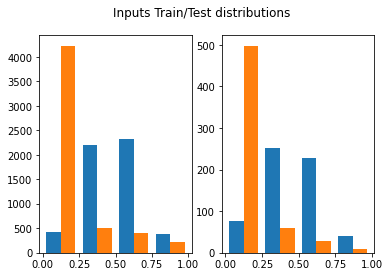

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=4)
ax2.hist(X_test, bins=4)
plt.show()

In [56]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

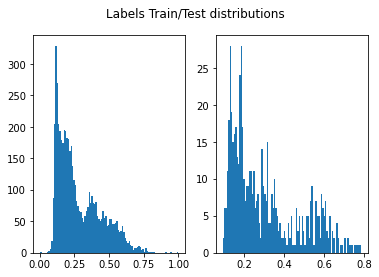

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

# Batching Logic 

This section defines the necessary utilities for producing batches of variable length sequences.

In [18]:
def GetInitialBatchIndex(X, input_len, prediction_window_len=48):
  """ 
      Returns a random index from which to sample `input_len` inputs.
      This was written separately so that we can test that it produces an
      even distribution among potential starting indices.
  """
  left_idx = np.random.randint(
      low=0,
      high=max(len(X) - prediction_window_len * 2 - input_len - 1, 1))
  right_idx = left_idx + input_len - 1
  return left_idx

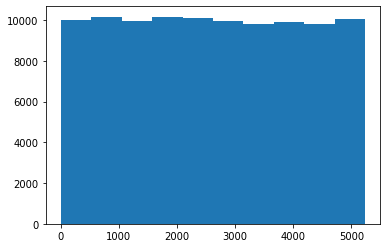

In [19]:
# Confirm that starting indices for bathches are evenly distributed.
no_trials = 100000
start_indices_samples = []

for _ in range(no_trials):
  start_indices_samples.append(GetInitialBatchIndex(X_train, 15))

plt.hist(start_indices_samples)
plt.show()

In [20]:
def GetSample(y, input_len, prediction_window_len=48, use_noise_reg=False):
  """Return a single input sequence and its respective targets.
  
  Args:
    y: np.array from which to extract the regression targets corresponding
       to the selected inputs.
    prediction_window_len: length of the prediction window, which describes
      how many predictions we have to do for a given input sequence.
    use_noise_reg: bool indication whether to inject the labels with noise.

  Return:
    y_input_tensor: tensorized inputs.
    y_target_tensor: tensorized targets.

  Note, since we can use forecasts, we also include future data in our
  sequences.
  """
  left_idx = GetInitialBatchIndex(y, input_len, prediction_window_len)
  right_idx = left_idx + input_len - 1

  # Add `prediction_window_len` to our right index, since we can use future
  # values as well, given that we always expect to have forecasts availabel.
  y_input_tensor = torch.Tensor(
      y[left_idx : right_idx + 1])
  y_target_tensor = torch.Tensor(
      y[right_idx + 1 : prediction_window_len + right_idx + 1])

  return (y_input_tensor,
          InjectGaussianNoise(y_target_tensor) 
          if use_noise_reg else y_target_tensor)

In [21]:
def GetBatch(y, batch_size, input_len, device, prediction_window_len=48,
             use_noise_reg=False):
  y_inputs, y_targets = [], []
  for _ in range(batch_size):
    y_input_tensor, y_target_tensor = GetSample(y, 
                                   input_len,
                                   prediction_window_len,
                                   use_noise_reg)
    y_inputs.append(y_input_tensor)
    y_targets.append(y_target_tensor)
  return (torch.stack(y_inputs).to(device),
          torch.stack(y_targets).to(device))

In [108]:
y1, y2 = GetBatch(y_train, 12, 5, 'cpu')
y1.shape, y2.shape

(torch.Size([12, 5]), torch.Size([12, 48]))

# Neural Models Definitions

This section covers defining the classes needed for our regression models:

We shall employ a seq2seq approach, where we unroll a Luong attention based decoder step by step, instead of predicting everything at a time.



In [20]:
def InjectGaussianNoise(X, isotropic_std=0.1):
  return torch.normal(mean=X, std=isotropic_std)

In [22]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = torch.nn.Linear(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, True, 
                                batch_first=True)
        
    def forward(self, inputs, hidden=None):
        embedded = self.embedding(inputs)
        output, hidden = self.gru(embedded)
        return output, hidden

# Training/Testing Setup

This section covers the training procedure, records training metrics, plots train/test loss curves, and shows how to do inference with a trained model.

In [23]:
def _GetDevice():
  return torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [62]:
def train(device=_GetDevice(),
          epochs=30,
          batch_size=32,
          prediction_window_len=24,
          input_size=1,
          hidden_size=24):

  # Encoder, optimizer instantiations.
  encoder = EncoderRNN(input_size=input_size,
                       hidden_size=hidden_size).to(device)

  enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
  # Regression loss.
  mse_loss = torch.nn.MSELoss() 

  iterations_per_epoch = len(df) // batch_size
  train_losses, val_losses = [], []
  print(epochs, iterations_per_epoch)

  for epoch in range(epochs):
    for iter in range(iterations_per_epoch):
      enc_optimizer.zero_grad()

      # Sample varying sequence lengths to use for prediction.
      input_len = np.random.randint(low=2, high=12)
      inputs, targets = GetBatch(y_train,
                                batch_size,
                                input_len,
                                device,
                                prediction_window_len)
      
      predictions = torch.mean(encoder(inputs[..., None])[0], dim=1)

      # Compute and record MSE loss.
      train_loss = mse_loss(predictions, targets)
      train_losses.append(train_loss)

      # Backprop and update parameters.
      train_loss.backward()
      enc_optimizer.step()
      
      with torch.no_grad():
        input, targets = GetBatch(y_test, batch_size,
                                  input_len, device, prediction_window_len)
        predictions = torch.mean(encoder(inputs[..., None])[0], dim=1)

        val_loss = mse_loss(predictions, targets)
        val_losses.append(val_loss)

      if epoch % 10 == 0 and iter == iterations_per_epoch % 5 == 0:
        mae_loss = torch.nn.L1Loss()(predictions, targets) * y_train_max

        print('Epoch:', epoch)
        print('Train loss:', train_loss.item())
        print('Val loss:', val_loss.item())
        print('Val loss:', mae_loss.item())

        print('\n')
  return encoder, train_losses, val_losses

In [63]:
# Customize this loop however you prefer.
encoder, train_losses, val_losses = train()

30 185
Epoch: 0
Train loss: 0.16321513056755066
Val loss: 0.1413751095533371
Val loss: 2864.18896484375


Epoch: 10
Train loss: 0.004984874278306961
Val loss: 0.04585590958595276
Val loss: 1597.486572265625


Epoch: 20
Train loss: 0.006965005304664373
Val loss: 0.04365427419543266
Val loss: 1647.28759765625




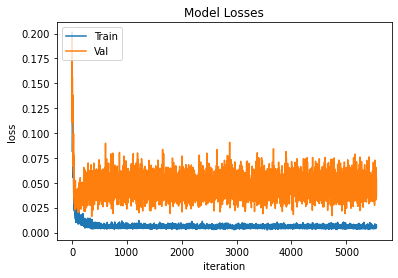

In [32]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.title('Model Losses')
plt.legend(['Train', 'Val'], loc='upper left')

plt.ylabel('loss')
plt.xlabel('iteration')

plt.show()

Input length: 3


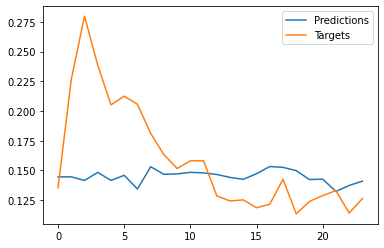

In [49]:
with torch.no_grad():
  input_len = np.random.randint(low=2, high=12)
  print('Input length:', input_len)
  inputs, targets = GetBatch(y_test,
                             batch_size=1,
                             input_len=input_len,
                             device=_GetDevice(),
                             prediction_window_len=24)
        
  predictions = torch.mean(encoder(inputs[..., None])[0], dim=1)
  plt.plot(predictions.cpu().numpy()[0], label='Predictions')
  plt.plot(targets.cpu().numpy()[0], label='Targets')
  plt.legend()
  plt.show()